# Assignment 12

In this assignment we'll examine our hidden Markov models and state space models a bit further!

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!


In [2]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

## Problem 1

In lecture, I mentioned that the availability of the observed data likelihood $L(y_{1:n} \mid \theta)$ comes from what happens when we using Bayes rule on the states. In this problem we will prove why!


Our class' primary goal usually isn't *filtering*; however, it is surprising to learn that understanding it is important to successfully do parameter inference for these kinds of time series models. 

Filtering consists of coming up with recursive formulas for $p(x_t \mid y_{1:t}, \theta)$. In other words, find $p(x_t \mid y_{1:t}, \theta)$ in terms of $p(x_{t-1} \mid y_{1:t-1}, \theta)$.

Prove the filtering recursions. In other words, show the following



#### 1

Write $p(z_t \mid y_{1:t-1}, \theta)$ in terms of $f(z_t \mid z_{t-1}, \theta)$ and the previous filtering distribution. How does your answer change for discrete and continuous states?


#### 2

Show that Bayes' rule holds for states. In other words, show

$$
p(z_t \mid y_{1:t}, \theta) \propto g(y_t \mid z_t, \theta)p(z_t \mid y_{1:t-1}, \theta)
$$

**Roughly speaking** which term plays the role of "prior", and which term plays the role of "likelihood?"

#### 3

Show that the normalizing constant for the above is $p(y_t \mid y_{1:t-1},\theta)$. Generally speaking, when is it something we can calculate as a `float` in Python? 

Hint: think back to all of our early modules! I am simply looking for a key word/phrase that starts with the letter "c!"

#### 4

Only when the data are independent is it true that

$$
L(y_{1:T} \mid \theta) = p(y_1 \mid \theta)p(y_2 \mid  \theta) \times \cdots \times p(y_T \mid \theta)?
$$

This may not be appropriate to assume when dealing with time series data. 

Why is it **always** true that

$$
L(y_{1:T} \mid \theta) = p(y_1 \mid \theta)p(y_2 \mid y_1, \theta) \times \cdots \times p(y_T \mid y_{1:T-1},\theta)?
$$

----------------------------

These four problems, taken together, show when and why the observed data likelihood is the product of all the little `float`s we calculate by filtering through the time series! :)

Here is my work for all of problem 1. Each section is labelled. I accidentally wrote 2.2 and 2.3. They are really supposed to be 1.2  and 1.3.

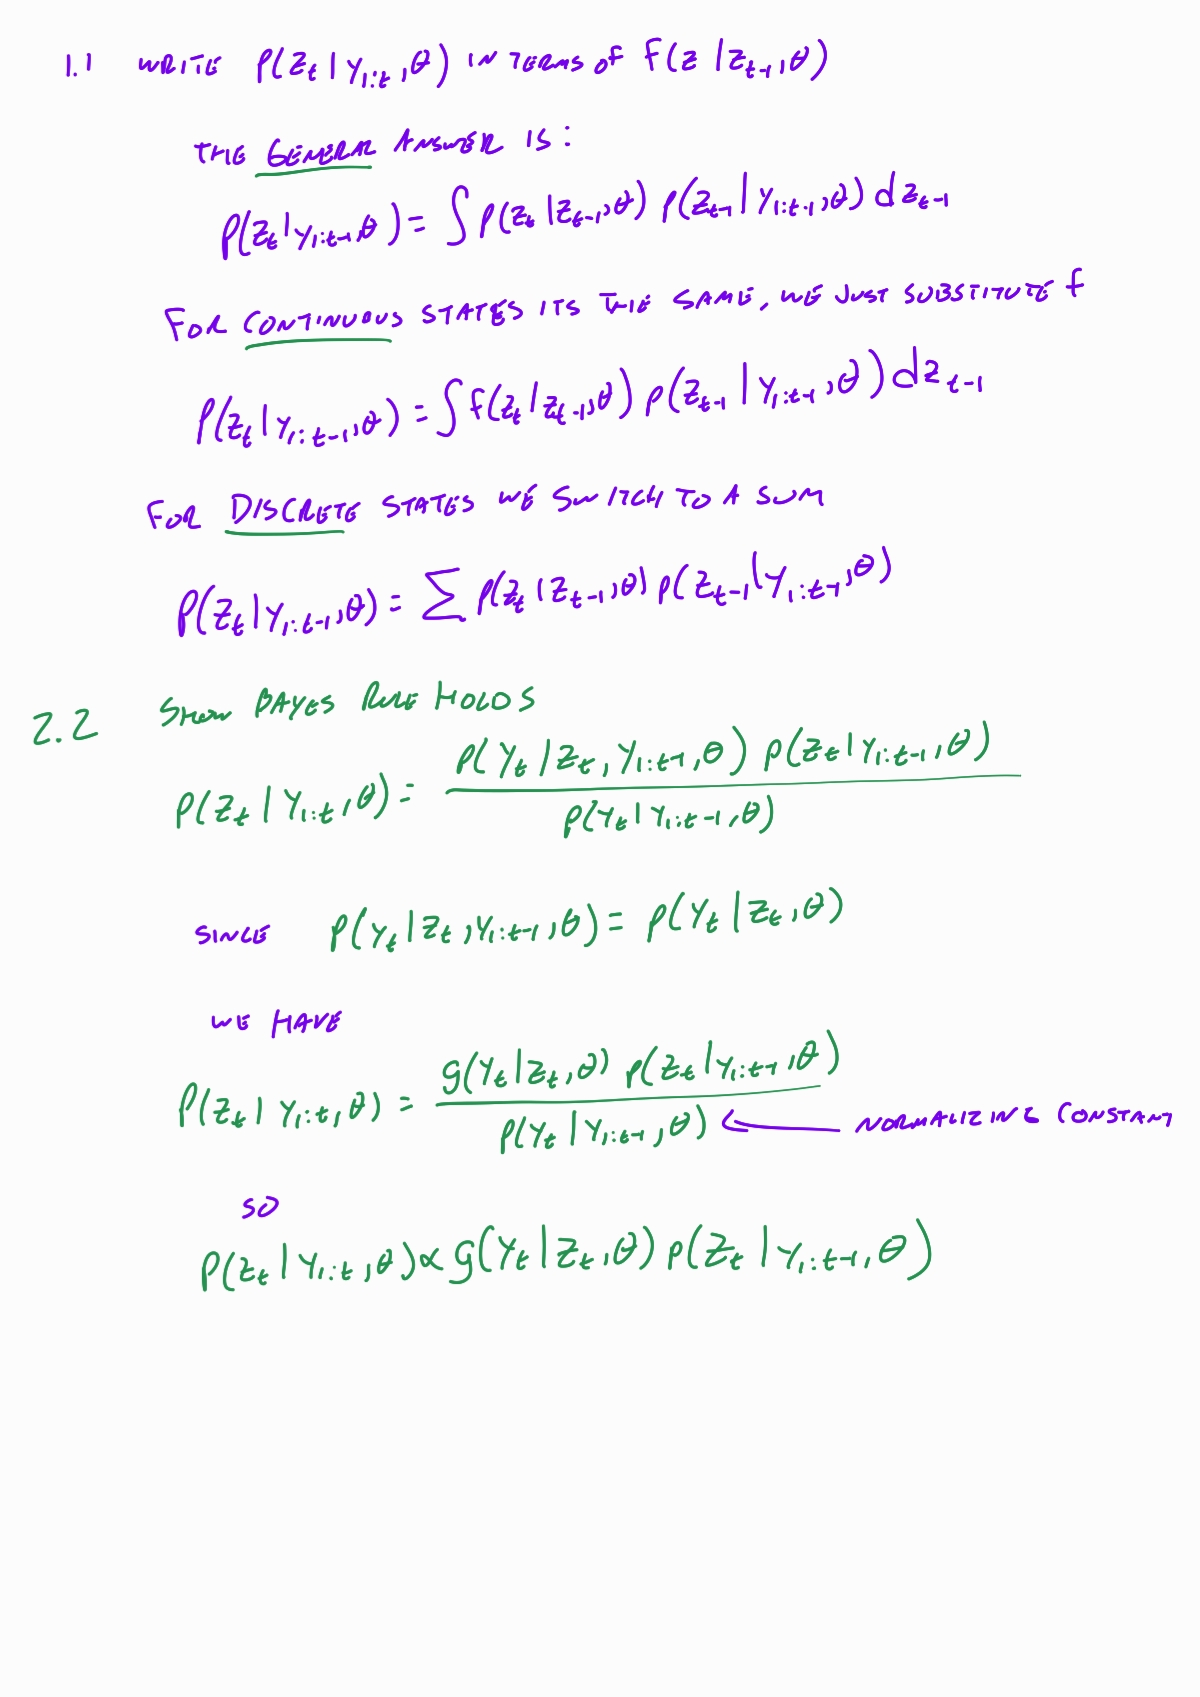

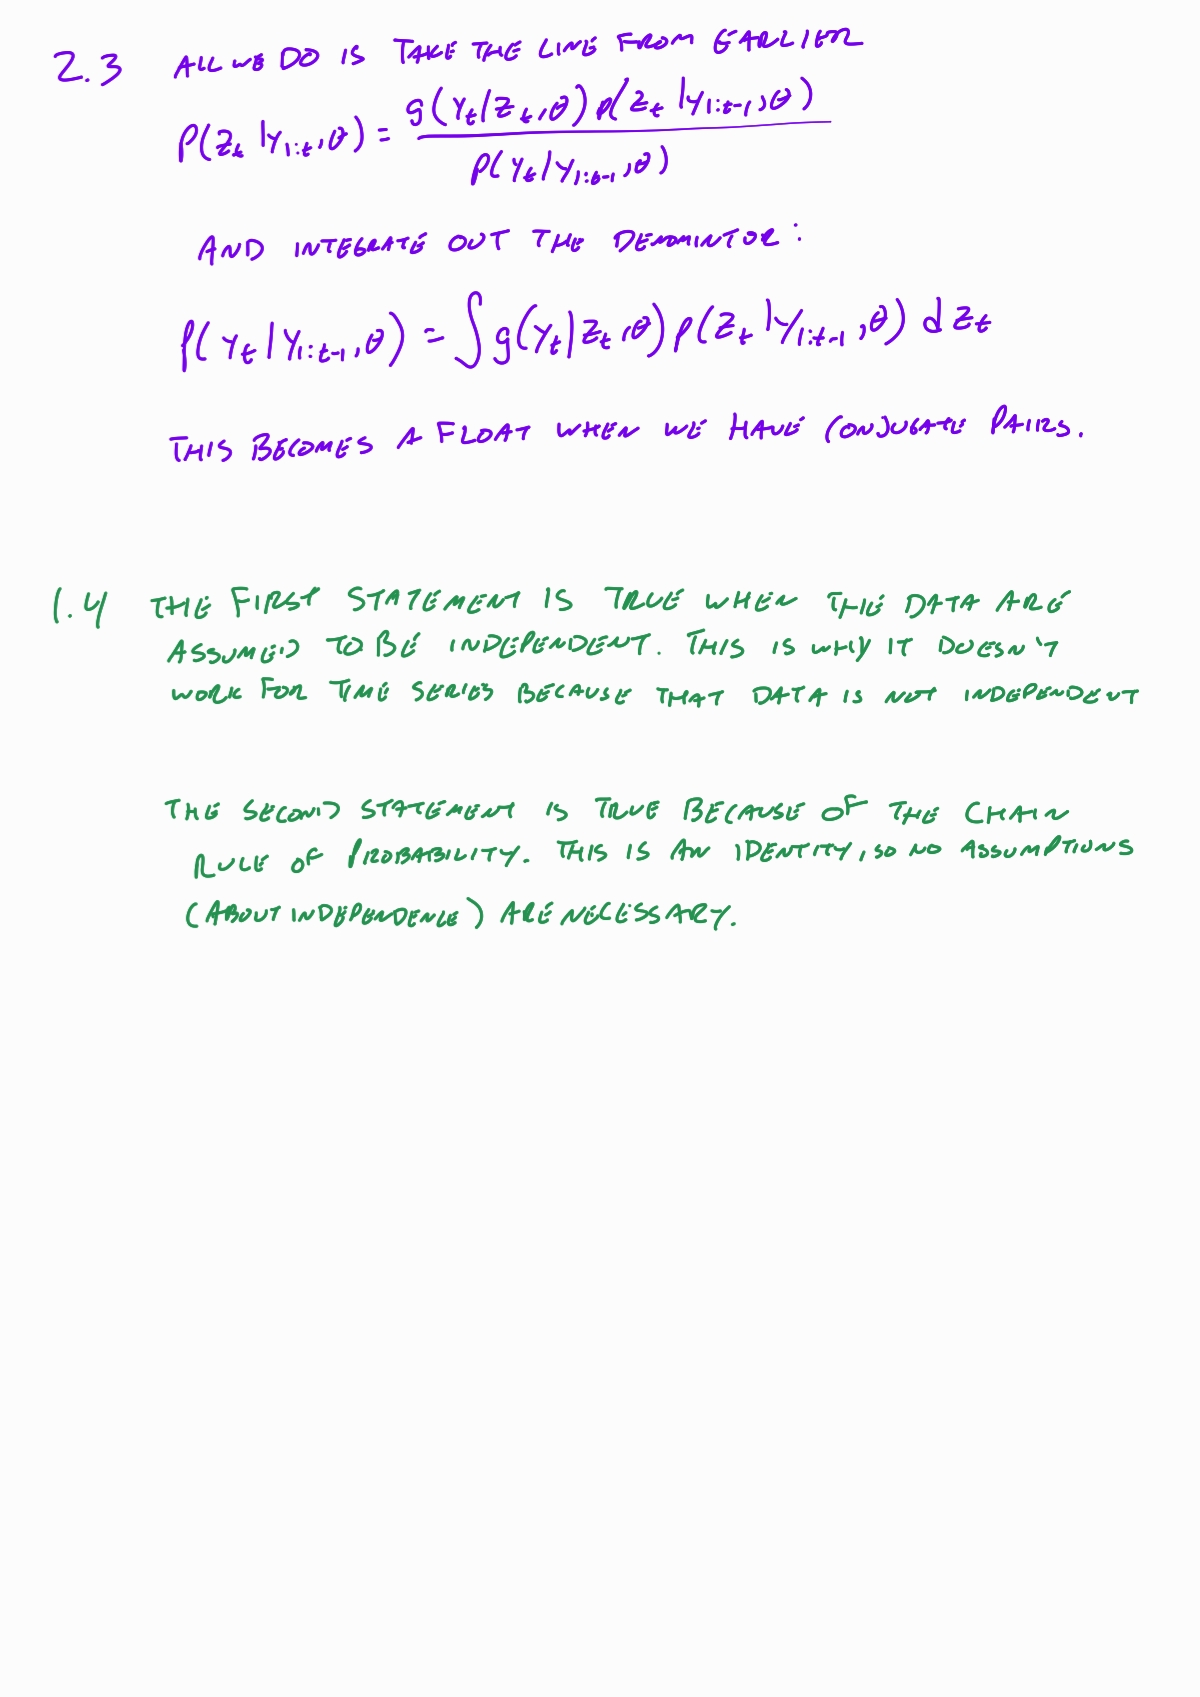

## Problem 2

Recall the stochastic volatility model for univariate returns data:

$$
y_t = \exp[z_t/2]\epsilon_t \hspace{10mm} \text{    or    } \hspace{10mm}  g(y_t \mid z_t, \theta) = \text{Normal}(0, \exp[z_t])
$$
and
$$
z_t = \mu + \phi(z_{t-1} - \mu) + w_t \hspace{10mm} \text{    or    } \hspace{10mm}  f(z_t \mid z_{t-1}, \theta) = \text{Normal}(\mu + \phi(z_{t-1} - \mu), \sigma^2)
$$

and to start $z_1$ starts in the *stationary distribution* of the Markov chain.

$\theta = (\mu, \phi, \sigma^2)$

Notice that the returns $y_t$ have mean $0$. For stocks, this might be a poor assumption, because they tend to drift upward over the long run. In practice, people sometimes preprocess their stock returns by subtracting a "risk free rate." Other times, they'll modify the model to include an average rate of return (call it $\alpha$).

### 1

Write down a modified model that includes a "drift" term, or a term that shift's the normal distribution for $g(y_t \mid z_t, \theta)$. 

To add a drift term I added alpha to the parameters block with a normal(0.05, 0.5). This will allow the daily return to be slightly positive (as stocks generally grow over time) but still be able to have the occasional spike either direction stocks have (I did some research online about the general behaviour of stocks and this seemed to be a good fit).

In [72]:
model_code = os.path.join('.', 'svadj.stan')
model = CmdStanModel(stan_file=model_code)

18:44:37 - cmdstanpy - INFO - compiling stan file /tmp/tmp82gxlqu5/tmp20cyxwcl.stan to exe file /bml24/Assignment 12/svadj
18:44:52 - cmdstanpy - INFO - compiled model executable: /bml24/Assignment 12/svadj


### 2

Pick your favorite stock ticker and estimate this new improved model using a data set different than the one provided in lecture. 

How does the inclusion of this new parameter change the the posterior shape/location of the other parameters?

I downloaded Starbucks stock (not cause it was my favorite but because so many stock downloads were behind paywalls but I found this for free). The data is year-to-date for 2025 as of 8/5/2025 making the length of this dataset 147.

(array([ 1.,  2.,  3., 32., 81., 18.,  5.,  3.,  0.,  1.]),
 array([-10.1375733 ,  -7.86050303,  -5.58343276,  -3.30636249,
         -1.02929222,   1.24777805,   3.52484832,   5.80191858,
          8.07898885,  10.35605912,  12.63312939]),
 <BarContainer object of 10 artists>)

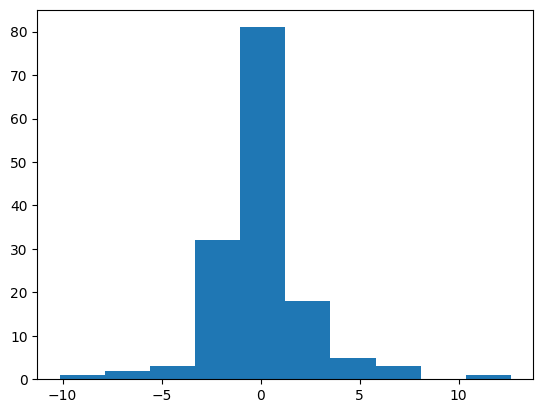

In [21]:
sbux = pd.read_csv("starbucks.csv")['Close/Last'].pct_change()[1:]*100
plt.hist(sbux)

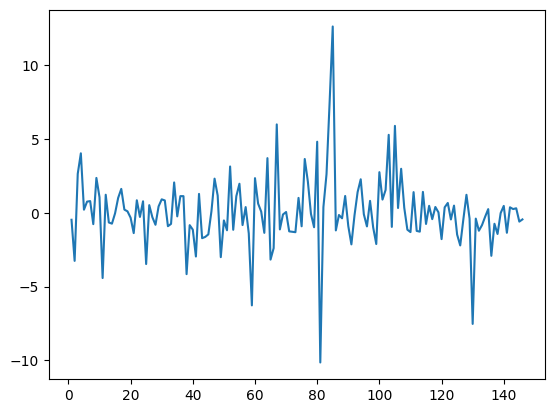

In [22]:
plt.plot(sbux)

THe data appears to be fairly concentrated about 0 with some up and downs typical of stocks. There is a large spike both directions around data number 80 (with the omission of weekends that puts that around the end of April beginning of May).

In [73]:
T = len(sbux)
my_dict = {'T' : T, 'y' : sbux[:T]}
fit = model.sample(data = my_dict)

18:44:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:54 - cmdstanpy - INFO - CmdStan done processing.
18:44:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'svadj.stan', line 23, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is -nan, but must be positive! (in 'svadj.stan', line 18, column 2 to column 49)
Consider re-running with show_console=True if the above output is unclear!


In [74]:
fit.summary().iloc[:10,]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-232.716000,1.592440,22.763500,-265.777000,-234.915000,-191.909000,204.340,63.2435,1.034110
mu,0.951269,0.005777,0.243594,0.562776,0.949117,1.334870,1777.940,550.2760,1.000420
phi,0.382839,0.012787,0.228644,-0.017791,0.396040,0.744020,319.731,98.9573,1.014350
sigma,1.134170,0.013304,0.212995,0.790676,1.132750,1.482920,256.328,79.3340,1.027260
alpha,-0.095161,0.002460,0.130841,-0.311593,-0.094457,0.121754,2828.340,875.3770,1.000230
z[1],0.715217,0.025288,1.203360,-1.295000,0.714012,2.700720,2264.390,700.8310,1.003310
z[2],1.832760,0.012456,0.790370,0.623576,1.770290,3.195710,4026.240,1246.1300,1.000030
z[3],1.878090,0.012727,0.826443,0.592499,1.831200,3.270200,4217.000,1305.1700,0.999889
z[4],2.100690,0.012939,0.761204,0.964941,2.046880,3.440100,3461.040,1071.2000,1.001220
z[5],0.681680,0.025148,1.156820,-1.290670,0.708834,2.559040,2116.040,654.9170,1.002560


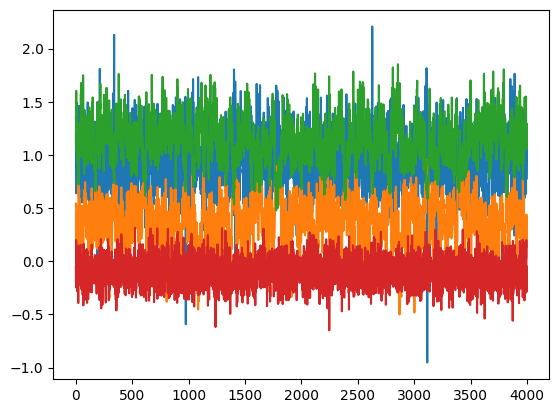

In [76]:
plt.plot(fit.draws_pd()[['mu']])
plt.plot(fit.draws_pd()[['phi']])
plt.plot(fit.draws_pd()[['sigma']])
plt.plot(fit.draws_pd()[['alpha']])

All the $\hat{R}$ values look good and the caterpillars look nice and fuzzy.

array([[<Axes: xlabel='mu', ylabel='mu'>,
        <Axes: xlabel='phi', ylabel='mu'>,
        <Axes: xlabel='sigma', ylabel='mu'>,
        <Axes: xlabel='alpha', ylabel='mu'>],
       [<Axes: xlabel='mu', ylabel='phi'>,
        <Axes: xlabel='phi', ylabel='phi'>,
        <Axes: xlabel='sigma', ylabel='phi'>,
        <Axes: xlabel='alpha', ylabel='phi'>],
       [<Axes: xlabel='mu', ylabel='sigma'>,
        <Axes: xlabel='phi', ylabel='sigma'>,
        <Axes: xlabel='sigma', ylabel='sigma'>,
        <Axes: xlabel='alpha', ylabel='sigma'>],
       [<Axes: xlabel='mu', ylabel='alpha'>,
        <Axes: xlabel='phi', ylabel='alpha'>,
        <Axes: xlabel='sigma', ylabel='alpha'>,
        <Axes: xlabel='alpha', ylabel='alpha'>]], dtype=object)

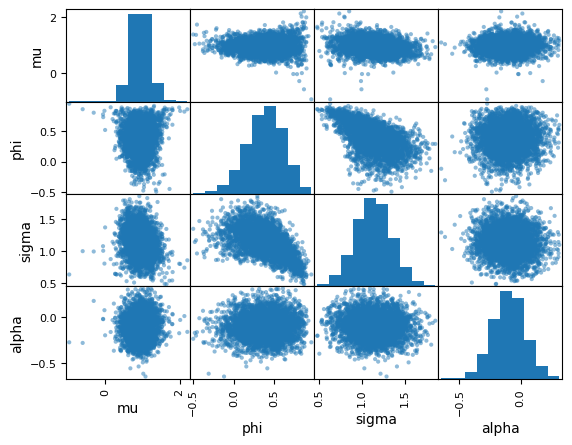

In [75]:
tmp = fit.draws_pd()[['mu','phi','sigma', 'alpha']]
pd.plotting.scatter_matrix(tmp)

There are definite similarities for the parameters in the notebook and these parameters, but they have changed. Mu looks similar (a bit more blobish vertical than blobish slanted) but is now positive (almost mirrored over 0). Phi stayed very close to the same with not many departures. Sigma now seems more symmetric than skewed left and has more range (the minimums seem to be about the same though).

### 3

Plot posterior estimates for your **latent states** over time. Which periods were relatively volatile? Do you have any hypotheses about why this may be the case?

Here is the graph of posterior over time.

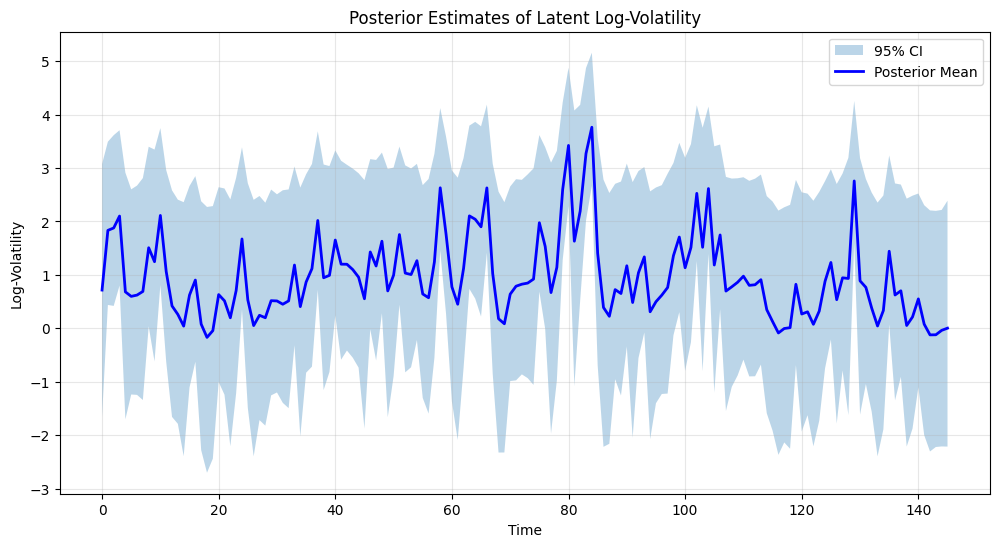

In [85]:
z_samples = fit.stan_variable('z')

z_mean = np.mean(z_samples, axis=0)
z_lower = np.percentile(z_samples, 2.5, axis=0)
z_upper = np.percentile(z_samples, 97.5, axis=0)

plt.figure(figsize=(12, 6))
time_index = np.arange(len(z_mean))
plt.fill_between(time_index, z_lower, z_upper, alpha=0.3, label='95% CI')
#plt.plot(time_index, sbux, 'g-', linewidth=2, label='Actual Stock')
plt.plot(time_index, z_mean, 'b-', linewidth=2, label='Posterior Mean')
plt.xlabel('Time')
plt.ylabel('Log-Volatility')
plt.title('Posterior Estimates of Latent Log-Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

It appears as though the most volatility happened around the 80 day mark just like in the actual data. If you plot the real data over this one (I have it off right now for clarity but you can see the line of code) it appears to miss a decent amount. I'm not sure why this is. It is interesting that it seems to capture the volatility correctly but doesn't always do it correctly.  
To help make sure I saw the volatility correctly I graphed the volatility below.

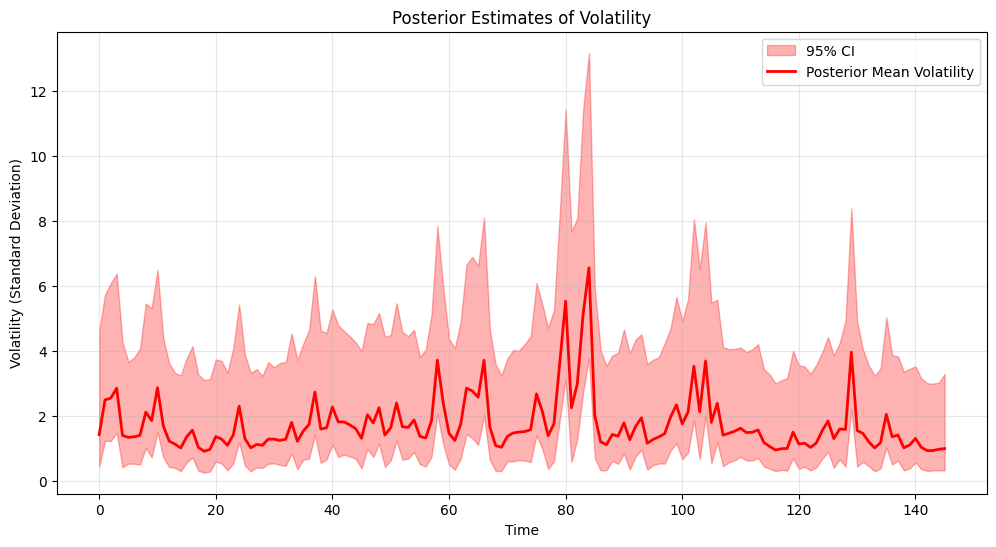

In [78]:
vol_mean = np.exp(z_mean / 2)
vol_lower = np.exp(z_lower / 2)
vol_upper = np.exp(z_upper / 2)
 
plt.figure(figsize=(12, 6))
plt.fill_between(time_index, vol_lower, vol_upper, alpha=0.3, color='red', label='95% CI')
plt.plot(time_index, vol_mean, 'r-', linewidth=2, label='Posterior Mean Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility (Standard Deviation)')
plt.title('Posterior Estimates of Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Here you can clearly see the largest volatility is around the 80 day mark (end April/beginning May). I think this about the time that the Trump tariffs went into place. Starbucks imports a lot of their coffee so it would make sense that that would cause Starbucks stock to fluctuate wildly as the market figures out how the tariffs effect the prices of Starbucks coffee and their profits. Also with a lot of things potentially becoming more expensive maybe coffee is the thing people cut out? There was a lot of uncertainty there.